<a href="https://colab.research.google.com/github/yoav1131/Deep-Learning-Course/blob/main/GANs_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks

This notebook presents a simple implementation of a generative adversarial network (GAN). In paricular, we train the GAN using the MNIST dataset, and hence we use it to generate images from the domain of $28 \times 28$ grayscale handwritten digits.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import numpy as np
from torchvision import datasets, transforms

Loading MNIST data, we only use the training set (without labels)

In [2]:
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.00MB/s]


We will define the following function for visualizing a list of images:

In [3]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
  fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
  for ax, img in zip(axes.flatten(), samples[epoch]):
    img = img.detach().cpu()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28, 28)), cmap='Greys_r')

# Adversarial Training

A generative adversarial network (GAN) model consists of two models:


*   A Generator network $G(\cdot)$ that takes in latent embedding (usually random noise) and generates an images like those that exists in the training data.

*   A Discriminator network $D(\cdot)$ that tries to distnguish between real images from the training data, and fake images produced by the generator.

In essense, we have two neural networks that are adversaries: the generator wants to fool the discriminator, and the discriminator wants to avoid being fooled.



# Training Function

What loss function should we optimize?

**Discriminator Objective:** Consider thefollowing quantity:
    
$\hspace{60pt} Pr(D(\cdot) \hspace{2pt} \text{correctly identifies real images}) + Pr(D(\cdot) \hspace{2pt} \text{correctly identifies images generated by} \hspace{2pt} G(\cdot))$

A good discriminator would want to maximize the above quantity by altering its parameters.

**Generator Objective:** Likewise, a good generator would want to minimize the above quantity. Actually, the only termo that the generator controls is

$\hspace{160pt} Pr(D(\cdot) \hspace{2pt} \text{correctly identifies images generated by} \hspace{2pt} G(\cdot))$

So the best discriminator is a binary classifier, we will use binary cross entropy loss. For the discrimnator, we use the label $0$ to represent a fake image, and $1$ to represent a real image. For the real images, we want *D(real_images) = 1*. That is, we want the discriminator to classify the real images with a *label = 1*. indicating that these are real.

To help the discriminator generalize better, the labels are reduced a bit from $1.0$ to $0.9$. For this, we will use the parameter snooth; if True, then we should smooth out labels.

In PyTorch, this looks like <code> labels = torch.ones(size) * 0.9 </code>.


In [4]:
# calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label snoothing
    if smooth:
      # smooth real labels = 0.9
      labels = torch.ones(batch_size) * 0.9
    else:
      labels = torch.ones(batch_size) # real labels = 1.0

    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size) # fake labels = 0
  criterion = nn.BCEWithLogitsLoss()
  # calculate loss
  loss = criterion(D_out.squeeze(), labels)
  return loss

Here is a function for training a GAN, by alternating between the discriminator objective and the generator objective in an iterative fashion. For every mini batch of data, we train the discriminator for one iteration, and then we train the generator for one iteration.

In [16]:
def train(G, D, train_loader, z_size=100, lr=0.001, num_epochs=5):
    d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
    g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)

    # keep track of loss and generated "fake" samples
    samples = []
    losses = []

    print_every = 400

    # get some fixed data for sampling. These are images that are held constant
    # throughout training, and allows ius to inspect the model's performance

    sample_size = 16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()

    # train the network
    D.train()
    G.train()
    for epoch in range(num_epochs):
        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = real_images.size(0)

            # === Important rescaling step, since the generator output layer is tanh ===
            real_images = real_images * 2 - 1 #rescale input images from [0,1) to [-1, 1)

            # ===============================================
            #             Train The Discriminator
            # ===============================================

            d_optimizer.zero_grad()

            # 1. Train with real images

            # compute the discriminator losses on real images
            # smooth real labels
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth=True)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)

            # compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up losses and do back propagation
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()



            # ===============================================
            #             Train The Generator
            # ===============================================
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)

            # compute the discriminator loses on fake images using flipped labels
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # do back propagation
            g_loss.backward()
            g_optimizer.step()

            # print some loss stats
            if batch_i % print_every == 0:
              # print discriminator and generator loss
              print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                  epoch+1, num_epochs, d_loss.item(), g_loss.item()
              ))

        ## after each epoch ##
        # append discriminator and generator loss
        losses.append((d_loss.item(), g_loss.item()))

        # generate and save sample, fake images
        G.eval() # eval mode for generator samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to train mode

    # plot learning curve
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()


    return samples

# GAN Model

Let's set up a simple generator and a discriminator, which are comprised of fully connected layes.

**Discriminator:** Both the Discriminator and Generator are fully connected networks. One dofference between these models and the precious models we have built is that we are using a <code> nn.LeakyReLU</code> activation.

We have seen leaky ReLU activation before. LeakyReLU is a variant of the ReLU activation that lets some information through, even when its input is less than $0$. The layer <code>nn.LeakyReLU(0.2, inplace=True)</code> performs the computation:

$\hspace{200pt} LeakyReLU(x) = \begin{cases}
x, & x > 0 \\
0.2 \cdot x,  & x \leq 0
\end{cases}$

The discriminator is inherently a binary classifier, so we use a linear output layer with a single output neuron. Which is converted into a probability when computing the loss via the binary cross entropy computation. The resulting architecture is fully connected of sizes $28^2 \rightarrow 34*4 \rightarrow 32 * 2 \rightarrow 32 \rightarrow 1$ with intermediate Leaky ReLU activations and dropouts to avoid overfitting.

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
      super(Discriminator, self).__init__()

      # define hidden linear layers
      self.fc1 = nn.Linear(input_size, hidden_dim*4)
      self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
      self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)

      # final fully connected layes
      self.fc4 = nn.Linear(hidden_dim, output_size)

      # dropout layer
      self.dropout = nn.Dropout(0.3)

    def forward(self, x):
      # flatten image
      x = x.view(-1, 28*28)
      # all hidden layers
      x = F.leaky_relu(self.fc1(x), 0.2)
      x = self.dropout(x)
      x = F.leaky_relu(self.fc2(x), 0.2)
      x = self.dropout(x)
      x = F.leaky_relu(self.fc3(x), 0.2)
      x = self.dropout(x)
      # final layer
      out = self.fc4(x)

      return out

**Generatoe:** The generator maps the latent noise vector, which here is of size $100 \times 1$ into a fake handwritten digit image. Hence, its output is a $28^2$ vector which takes values in the range $[-1, 1)$ ising a <code>tanh</code> output layer, and can be reshaped in a $28 \times 28$ image.

In [17]:
class Generator(nn.Module):
      def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()

        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)

        # final fully connected layes
        self.fc4 = nn.Linear(hidden_dim*4, output_size)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

      def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = F.tanh(self.fc4(x))

        return out



Let's generate a model for the GAN and jointly train the generator and the discriminator.

Epoch [    1/  100] | d_loss: 1.3689 | g_loss: 0.7396
Epoch [    1/  100] | d_loss: 1.0348 | g_loss: 2.4757
Epoch [    1/  100] | d_loss: 1.0912 | g_loss: 1.7620
Epoch [    2/  100] | d_loss: 1.0181 | g_loss: 2.0598
Epoch [    2/  100] | d_loss: 1.3386 | g_loss: 1.2014
Epoch [    2/  100] | d_loss: 1.0540 | g_loss: 2.5917
Epoch [    3/  100] | d_loss: 1.2454 | g_loss: 2.3198
Epoch [    3/  100] | d_loss: 1.4612 | g_loss: 0.7848
Epoch [    3/  100] | d_loss: 1.3273 | g_loss: 0.7267
Epoch [    4/  100] | d_loss: 1.0693 | g_loss: 2.5244
Epoch [    4/  100] | d_loss: 1.2831 | g_loss: 1.4439
Epoch [    4/  100] | d_loss: 1.3201 | g_loss: 0.7972
Epoch [    5/  100] | d_loss: 1.2743 | g_loss: 0.8754
Epoch [    5/  100] | d_loss: 1.3410 | g_loss: 1.0168
Epoch [    5/  100] | d_loss: 1.0819 | g_loss: 1.3705
Epoch [    6/  100] | d_loss: 1.3051 | g_loss: 1.1805
Epoch [    6/  100] | d_loss: 1.2143 | g_loss: 0.9510
Epoch [    6/  100] | d_loss: 1.1118 | g_loss: 1.3583
Epoch [    7/  100] | d_loss

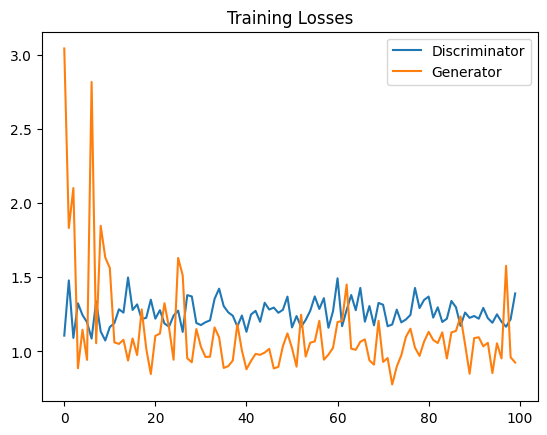

In [19]:
input_size = 784 # image size is 28*28
d_output_size = 1 # size of the discriminator output (real or fake)
hidden_dim = 32 #
z_size = 100 # latent vector size to give to the generator

# instantate discriminator and generator
D = Discriminator(input_size, hidden_dim, d_output_size)
G = Generator(z_size, hidden_dim, input_size)

samples = train(G, D, train_loader, z_size=100, lr=0.002, num_epochs=100)

GANs are notoriously difficult to train. One difficulty is that a training curve is **no** longer as helpful as it was for a suprvised learning problem!

The generator and discriminator losses tend to bounce up and down. Since both the generator and discriminator are changing over time. Tuning hyperparmeters is also much more difficault, because we don't have the training curve to guide us. Newer GAN models like Wasserstein GAN tries to alleviate some of these issues, and the incorporation of labels via conditional GANs is also known to help, but these are beyond the scope of this course.

To compound the difficulty of hyperparameters tuning GANs also takse a long time to train. It is tempting to stop early, but the effects of hyperparameters may not be nocticable until later on in training.

Let's see eaht images did we generate after the final epoch:

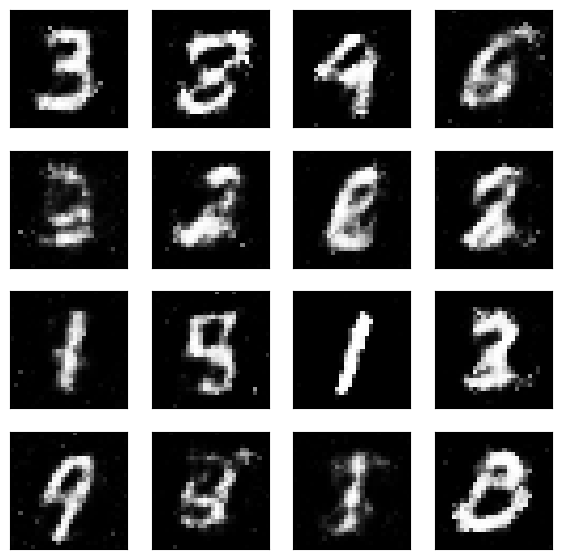

In [20]:
# -1 indicates final epoch's samples
view_samples(-1, samples)

How the quality of the images improves during training:

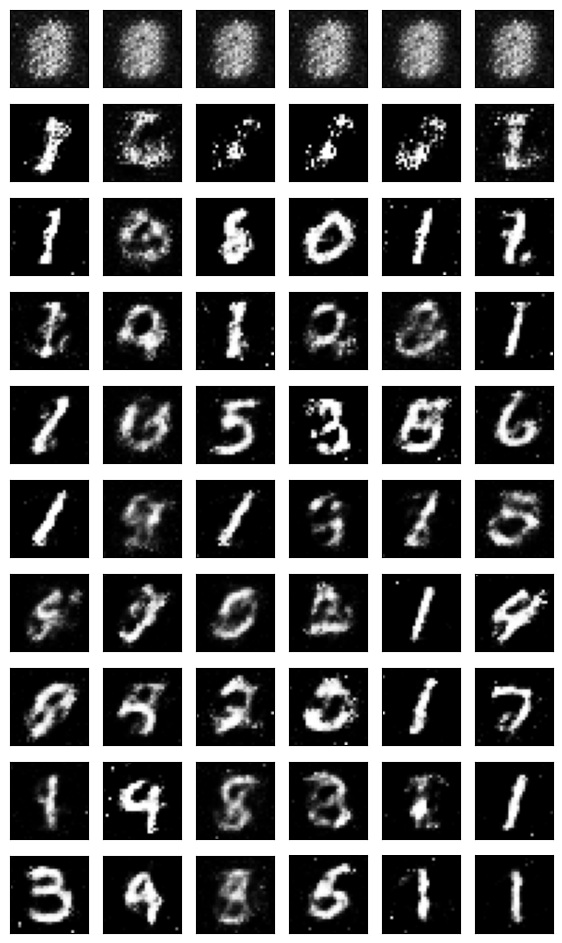

In [23]:
rows = 10 # split epochs into 10 so 100/10 = 10 epochs
cols = 6
fig,axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
  for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
    img = img.detach().cpu()
    ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)


and sampling new digits:

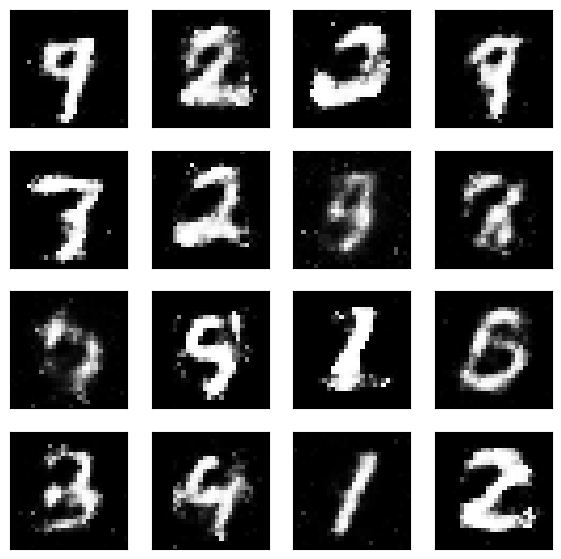

In [40]:
# randomly generated new latent vectors
sample_size = 16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval()
rand_images = G(rand_z)

view_samples(0, [rand_images])


You might have noticed in the images generated by our simple GAN that the model seems to only output a small number of digit types. This phenomenon is called *mode collapse*. A generator can optimize $Pr(D(\cdot) \hspace{2pt} \text{correctly identifies image generated by} \hspace{2pt} G(\cdot) )$ by learning to generate one type of input (e.g. one digit) really well, and not learning how to generate any other digit at all!